<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/Pink%20Noise%20Decoupling%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [24]:
!pip install qutip
!pip install matplotlib
!pip install scipy
!pip install colorednoise

In [25]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform
import colorednoise as cn

# 8. Pink Noise Decoupling

$H = -\frac{\omega_q+\delta\omega_q}{2}\sigma_z + A\sigma_x\cos{(\omega_{rot} t)} $

### 1) Pink Noise (Chap 5 Repeated)

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{|f_{k}|}}\sin(2\pi f_{k}t+\phi _{k}) \right ] $$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

In [26]:
def Chi_Ensemble(mu, sigma, num_seq):

  np.random.seed(0)
  X = np.random.normal(mu, sigma, num_seq)

  np.random.seed(1)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

In [27]:
def Pink_Noise(tlist, args):

  min_freq = args['min_freq']
  freq_repeat = args['freq_repeat']
  mu = args['mu']
  sigma = args['sigma']
  A = args['A_noise']

  t_shift = args['t_shift']

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)

  np.random.seed(2)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  f = A * (Chi_A[0]/np.sqrt((0+1)*min_freq)) * np.sin(2*np.pi*(0+1)*min_freq*(tlist+t_shift)+U_A[0])

  for k in range(1, freq_repeat, 1):
    f = f + A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*(tlist+t_shift)+U_A[k])

  return f

In [28]:
def func(t, b, a):
    return b + a * t

In [29]:
min_freq = 0.00001
freq_repeat = 100000
t_shift = 0

t_repeat = 2000
t_srt = 0
t_end = 1000

mu = 0
sigma = 1

A = 1

args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise': 2*np.pi*0.000001}

0.006537529619562277


Text(0, 0.5, 'Pink_Noise Distribution')

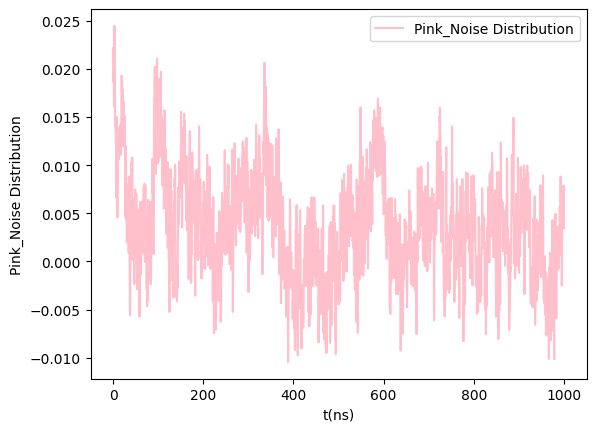

In [30]:
tlist = np.linspace(t_srt, t_end, t_repeat)
Pink_Noise_Sample = Pink_Noise(tlist, args)

print(np.sqrt(np.mean(Pink_Noise_Sample**2)))

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise_Sample, label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(ns)')
ax.set_ylabel('Pink_Noise Distribution')

[-1.19551766 -0.51684922]


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:625: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'FT Absolute Value (log scale)')

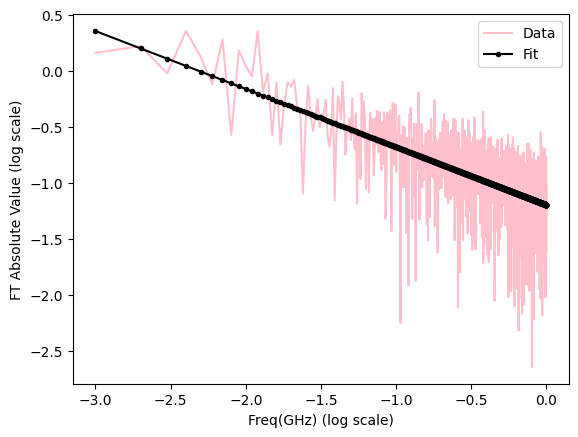

In [31]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise_Sample), d=tlist[1]-tlist[0]))

x_fft_plog = np.log10(x_fft[x_freq > 0])
x_freq_plog = np.log10(x_freq[x_freq > 0])

popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])
print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(GHz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')

### 2) Function Setting

In [32]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

# single pi & half pi cosine pulse for drive

def Pi_Cosine(t, args, T_cent):

    A = args['A']

    return (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

def Half_Pi_Cosine(t, args, T_cent):

    A = args['A']

    return 0.5 * (A + A * np.cos(2*A*(t-T_cent))) * (t > T_cent-np.pi/(2*A)) * (t < T_cent+np.pi/(2*A))

# single pi & half pi gaussian pulse for drive

def Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return A * np.exp(-A**2*(t-T_cent)**2/np.pi)

def Half_Pi_Gaussian(t, args, T_cent):

    A = args['A']

    return 0.5 * A * np.exp(-A**2*(t-T_cent)**2/np.pi)

In [33]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

  elif (Env==1 and Is_Pi==0):
    return Half_Pi_Cosine

  elif (Env==1 and Is_Pi==1):
    return Pi_Cosine

  elif (Env==2 and Is_Pi==0):
    return Half_Pi_Gaussian

  elif (Env==2 and Is_Pi==1):
    return Pi_Gaussian

# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [34]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [35]:
# time-dependent envelope for drive (lab frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_lab_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    # CP
    if (Func==0) :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)

    # CPMG & UDD
    else :

      pulse = Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_srt)

      for T_cent in Seq:
        pulse = pulse + Hrd_rot(Hrd_env(Env, 1), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': np.pi/2}, T_cent)

      pulse = pulse + Hrd_rot(Hrd_env(Env, 0), t, {'A': A, 'Omega_rd': Omega_rd, 'Phi': 0}, T_end)


    return pulse

In [36]:
# time-dependent envelope for drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hrd_rotating_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N']
    Env = args['Env']
    Func = args['Func']

    A = args['A']
    Omega_rd = args['Omega_rd']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': A}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': A}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': A}, T_end)

    return pulse

In [37]:
def T2_Measure(A, N, Func, noise):

  omega_q = 2 * np.pi * 6.0 * 1000
  omega_rd = 2 * np.pi * 6.0 * 1000

  sz = sigmaz()
  sx = sigmax()
  sy = sigmay()

  H0 = -0.5*omega_q*sz

  op_list = [basis(2,0)*basis(2,1).dag(), basis(2,1)*basis(2,0).dag()]


  T_end_seq = [10*i+10*N for i in range(20,101,5)]
  Off_diagonal_seq = []


  for i in range(20,101,5):

    tlist = np.linspace(-6, 10*i+10*(N+1)-6, 10000)

    result = mesolve(
      [H0, [-0.5*sz, noise], [sx, Hrd_lab_frame]],
      basis(2,0),
      tlist,
      args = {'A': A, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 10*i+10*(N+1), 'N': N, 'Env': 0, 'Func': Func},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
    )

    plus = result.expect[0]
    minus = result.expect[1]
    Off_diagonal_seq.append(plus, minus)


  return np.array(Off_diagonal_seq)

### 3) CP Rotating Frame

In [ ]:
Total_Offdiagonal = []

In [97]:
omega_q = 2 * np.pi * 6.0
omega_rd = 2 * np.pi * 6.0

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

H0 = -0.5*omega_q*sz
op_list = [sx, sy, sz, sp, sm]

tlist = np.linspace(-3, 50-3, 100000)
#[H0, [-0.5*sz, Pink_Noise_1], [sx, Hrd_lab_frame]],
#[[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],

result = mesolve(
  [[-0.5*sz, Pink_Noise], [0.5*sx, Hrd_rotating_frame]],
  basis(2,0),
  tlist,
  args = {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 50, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 0, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.01},
  e_ops = op_list,
  options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

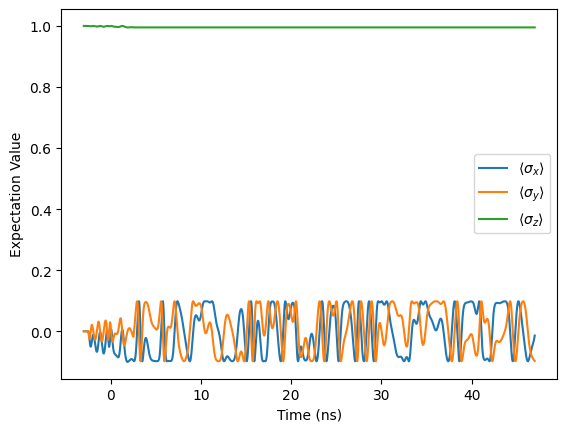

In [98]:
tlist = np.linspace(-3, 50-3, 100000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0], label = r'$\langle\sigma_x\rangle$')
ax.plot(tlist, result.expect[1], label = r'$\langle\sigma_y\rangle$')
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

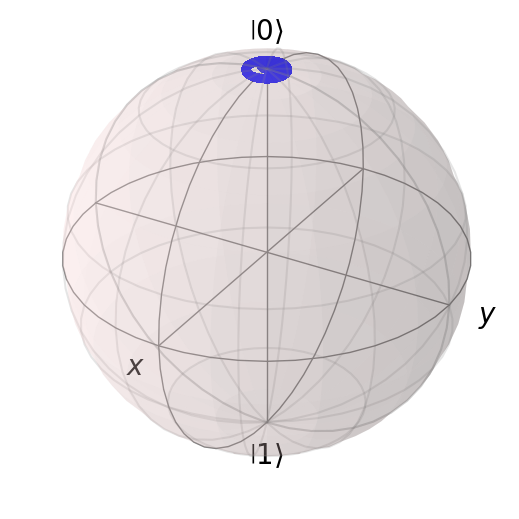

In [99]:
# Create Bloch sphere plot
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(result.expect, meth="s")
sphere.show()